In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_squared_error as mse, r2_score, classification_report

from lightgbm import LGBMRegressor, LGBMClassifier

seed = 42

In [2]:
np.random.seed(seed)

In [3]:
X, y = load_diabetes(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, shuffle=True, random_state=seed)

In [4]:
class GBRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, depth=3, coef_list=None, eta=0.1, num_iterations=100, subsample=1.):
        self.depth = depth
        self.eta = eta
        self.num_iterations = num_iterations
        if coef_list is None:
            self.coef_list = np.array([1.] * num_iterations)
        else:
            self.coef_list = coef_list
        self.trees = []
        self.subsample = subsample
        self.test_errors = [] # for task #2

    @staticmethod
    def __mean_squared_error(y_real, prediction):
        return np.sum(np.power(y_real - prediction, 2)) / len(y_real)

    @staticmethod
    def __bias(y, z):
        return (y - z)  

    def fit(self, X, y=None):
        for i in range(self.num_iterations):
            tree = DecisionTreeRegressor(max_depth=self.depth, random_state=seed)
            if len(self.trees) == 0:
                tree.fit(X, y)
            else:
                if self.subsample != 1.:
                    indices = np.arange(X.shape[0])
                    train_indices = np.random.choice(indices, size=int(self.subsample * X.shape[0]))
                    target = self.predict(X[train_indices])
                    tree.fit(X[train_indices], self.__bias(y[train_indices], target))
                else:
                    target = self.predict(X)
                    tree.fit(X, self.__bias(y, target))
            try:        
                self.test_errors.append(mse(y_test, self.predict(X_test)))
            except NameError:
                pass
            self.trees.append(tree)

    def predict(self, X):
        return np.array([np.sum([self.eta * coef * tree.predict([x])[0] for coef, tree in zip(self.coef_list, self.trees)]) for x in X])


In [5]:
gb = GBRegressor(depth=3, eta=0.5, num_iterations=10)

gb.fit(X_train, y_train)
train_pred = gb.predict(X_train)
test_pred = gb.predict(X_test)

print(f'Train MSE: {mse(y_train, train_pred):.3f}, R2 train: {r2_score(y_train, train_pred):.3f}')
print(f'Test MSE: {mse(y_test, test_pred):.3f}, R2 test: {r2_score(y_test, test_pred):.3f}')

Train MSE: 1444.138, R2 train: 0.761
Test MSE: 3085.592, R2 test: 0.442


In [6]:
lgbm = LGBMRegressor(boosting_type='gbdt', max_depth=3, learning_rate=0.5, n_estimators=10)

lgbm.fit(X_train, y_train)
train_pred = lgbm.predict(X_train)
test_pred = lgbm.predict(X_test)

print(f'Train MSE: {mse(y_train, train_pred):.3f}, R2 train: {r2_score(y_train, train_pred):.3f}')
print(f'Test MSE: {mse(y_test, test_pred):.3f}, R2 test: {r2_score(y_test, test_pred):.3f}')

Train MSE: 1773.648, R2 train: 0.707
Test MSE: 3051.604, R2 test: 0.448


In [7]:
train_errors, test_errors = [], []

for i in range(1, 31):
    gb = GBRegressor(depth=3, eta=0.5, num_iterations=i)
    gb.fit(X_train, y_train)
    train_pred = gb.predict(X_train)
    test_pred = gb.predict(X_test)
    train_errors.append(mse(y_train, train_pred))
    test_errors.append(mse(y_test, test_pred))

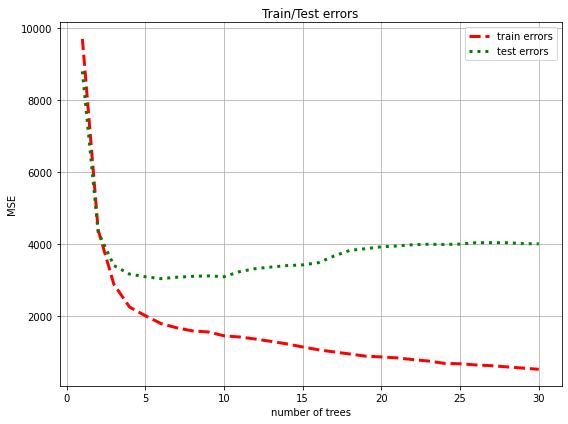

In [8]:
plt.figure(figsize=(8,6))
plt.title('Train/Test errors')
plt.plot(np.arange(1,31), train_errors, lw=3, c='red', label='train errors', ls='--')
plt.plot(np.arange(1,31), test_errors, lw=3, c='green', label='test errors', ls=':')
plt.grid()
plt.legend()
plt.ylabel('MSE')
plt.xlabel('number of trees')
plt.tight_layout()
plt.show()

In [11]:
train_errors, test_errors = [], []

for i in range(1, 10):
    gb = GBRegressor(depth=i, eta=0.5, num_iterations=5)
    gb.fit(X_train, y_train)
    train_pred = gb.predict(X_train)
    test_pred = gb.predict(X_test)
    train_errors.append(mse(y_train, train_pred))
    test_errors.append(mse(y_test, test_pred))

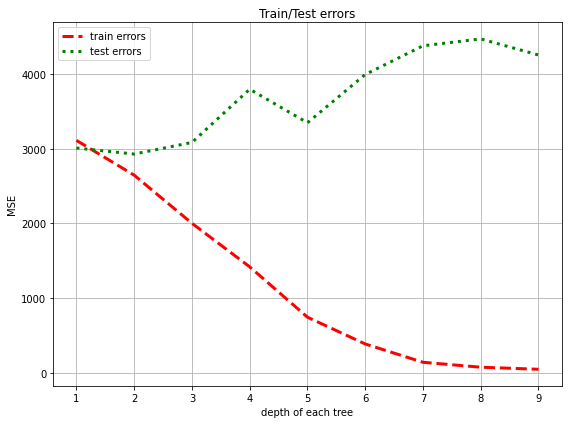

In [12]:
plt.figure(figsize=(8,6))
plt.title('Train/Test errors')
plt.plot(np.arange(1,10), train_errors, lw=3, c='red', label='train errors', ls='--')
plt.plot(np.arange(1,10), test_errors, lw=3, c='green', label='test errors', ls=':')
plt.grid()
plt.legend()
plt.ylabel('MSE')
plt.xlabel('depth of each tree')
plt.tight_layout()
plt.show()

При увеличении глубины базового алгоритма (дерева), а также при увеличении количества деревьев в ансамбле наблюдается сильное переобучение. Необходимо подбирать гиперпараметры для регуляризации: скорость обучения, использовать неглубокие деревья, применять регулиризацию функции потерь L1 и/или L2. Например, Subsample, colsample_bytree, различные индивидуальные параметры дерева для LGBM и его аналогов (CatBoost, XGBoost).

In [13]:
train_errors, test_errors = [], []

for i in range(1, 31):
    gb = GBRegressor(depth=3, eta=0.5, num_iterations=i)
    gb.fit(X_train, y_train)
    train_pred = gb.predict(X_train)
    test_pred = gb.predict(X_test)
    train_errors.append(mse(y_train, train_pred))
    test_errors.append(mse(y_test, test_pred))

train_errors_s, test_errors_s = [], []

for i in range(1, 31):
    gb = GBRegressor(depth=3, eta=0.5, num_iterations=i, subsample=0.5)
    gb.fit(X_train, y_train)
    train_pred = gb.predict(X_train)
    test_pred = gb.predict(X_test)
    train_errors_s.append(mse(y_train, train_pred))
    test_errors_s.append(mse(y_test, test_pred))

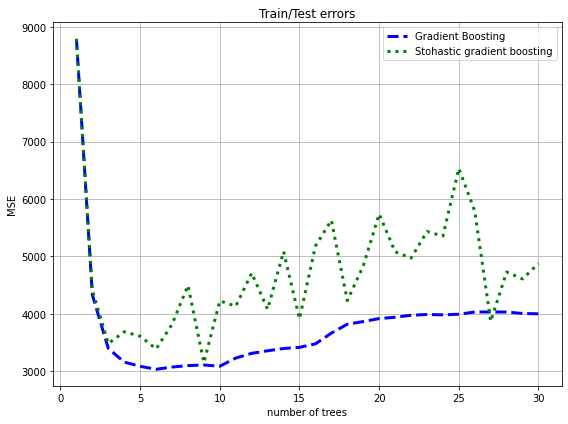

In [14]:
plt.figure(figsize=(8,6))
plt.title('Train/Test errors')
plt.plot(np.arange(1,31), test_errors, lw=3, c='blue', label='Gradient Boosting', ls='--')
plt.plot(np.arange(1,31), test_errors_s, lw=3, c='green', label='Stohastic gradient boosting', ls=':')
plt.grid()
plt.legend()
plt.ylabel('MSE')
plt.xlabel('number of trees')
plt.tight_layout()
plt.show()

In [15]:
sgb = GBRegressor(depth=3, eta=0.2, num_iterations=30, subsample=0.5)
sgb.fit(X_train, y_train)

In [16]:
gb = GBRegressor(depth=3, eta=0.2, num_iterations=30, subsample=1.)
gb.fit(X_train, y_train)

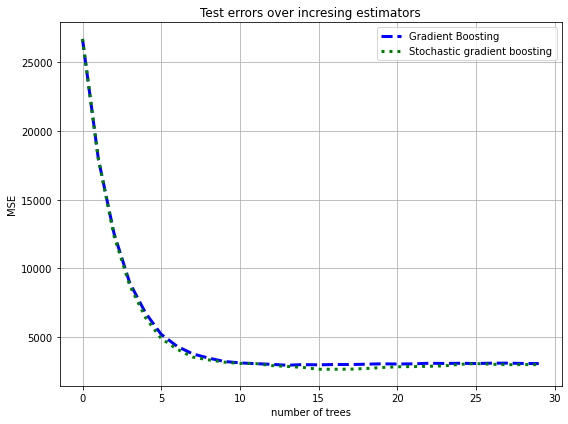

In [17]:
plt.figure(figsize=(8,6))
plt.title('Test errors over increasing number of estimators') 
plt.plot(gb.test_errors, lw=3, c='blue', label='Gradient Boosting', ls='--')
plt.plot(sgb.test_errors, lw=3, c='green', label='Stochastic gradient boosting', ls=':')
plt.grid()
plt.legend()
plt.ylabel('MSE')
plt.xlabel('number of trees')
plt.tight_layout()
plt.show()

### Дополнительно

In [18]:
class GBClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, n_estimators=20, learning_rate=0.1, min_samples_split=2, min_samples_leaf=5, 
                 max_depth=3, reg_lambda=0., reg_alpha=0., subsample=1., colsample_bytree=1.):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.trees = []
        for _ in range(n_estimators):
            tree = DecisionTreeRegressor(min_samples_split=self.min_samples_split, 
                                         min_samples_leaf=self.min_samples_leaf,
                                         max_depth=self.max_depth, 
                                         random_state=seed)
            self.trees.append(tree)
        self.losses = []
        self.coefs = None
        self.reg_alpha = reg_alpha
        self.reg_lambda = reg_lambda
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.cols = []

    def gradient(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - (y / p) + (1 - y) / (1 - p) 

    def fit(self, X, y=None):
        # self.coefs = np.array([.1] * self.n_estimators) 
        #y_pred = np.full(np.shape(y), np.mean(y, axis=0)) # define init model with average value of targets
        y_pred = np.full(np.shape(y), np.argmax(np.bincount(y)))/1. # define init model with most freq class
        for i in range(self.n_estimators):
            indices = np.arange(X.shape[0]) # subsample in data
            if self.subsample != 1.:
                #indices = np.random.choice(indices, size=int(self.subsample * X.shape[0]))
                indices = tuple(ShuffleSplit(n_splits=1, train_size=int(self.subsample * X.shape[0]), random_state=i).split(indices))[0][0].tolist()
            col_indices = np.arange(X.shape[1])
            if self.colsample_bytree != 1.:
                #col_indices = np.random.choice(col_indices, size=int(self.colsample_bytree * X.shape[1]))
                col_indices = tuple(ShuffleSplit(n_splits=1, train_size=int(self.colsample_bytree * X.shape[1]), random_state=i).split(col_indices))[0][0].tolist()
                self.cols.append(col_indices)

            gradient = self.gradient(y[indices], y_pred[indices]) # compute bias
            self.trees[i].fit(X[indices, :][:, col_indices], gradient)  # fit next tree on bias
            update = self.trees[i].predict(X[indices, :][:, col_indices]) # predict next instances
            # reg_lambda, reg_alpha: this is not how they implemented originally, here they add just 
            # some kind of linear combination to update of the current tree answer. Hence, lgbm reg_* != self reg_* !!! - originally: leaf weights are implemented
            # probably we could drop them off and fine-tune learning-rate more accurately - it is just my experiments
            y_pred[indices] -= self.learning_rate * (update + self.reg_lambda * y_pred[indices] + self.reg_alpha * np.sign(y_pred[indices])) # * self.coefs[i]
            self.losses.append(self.log_loss(y, self.activation(y_pred))) # just to have some insights after training
        return self

    @staticmethod
    def log_loss(y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return (-y.dot(np.log(p)) - ((1 - y).dot(np.log(1 - p))))

    def activation(self, y):
        return 1. / (1. + np.exp(-np.clip(y, -250, 250)))

    def predict(self, X):
        y_pred = self.predict_proba(X)
        y_pred = np.where(y_pred >= 0.5, 1, 0)
        return y_pred

    def predict_proba(self, X):
        y_pred = np.array([])

        for i, tree in enumerate(self.trees):
            if len(self.cols) == 0:
                update = tree.predict(X)
            else:
                update = tree.predict(X[:, self.cols[i]])
            update = np.multiply(self.learning_rate, update)
            y_pred = -update if not y_pred.any() else y_pred - update

        y_pred = self.activation(y_pred)
        return y_pred

In [86]:
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y, random_state=seed)

In [24]:
gbc = GBClassifier(learning_rate=.3, min_samples_leaf=20, min_samples_split=30, n_estimators=16, 
                   subsample=.6, colsample_bytree=0.5, reg_lambda=3.4, reg_alpha=1.1)
gbc.fit(X_train, y_train)

train_pred = gbc.predict(X_train)
test_pred = gbc.predict(X_test)
print(f'Train: \n', classification_report(y_train, train_pred, digits=3))
print(f'Test: \n', classification_report(y_test, test_pred, digits=3))

Train: 
               precision    recall  f1-score   support

           0      0.962     0.962     0.962       159
           1      0.978     0.978     0.978       267

    accuracy                          0.972       426
   macro avg      0.970     0.970     0.970       426
weighted avg      0.972     0.972     0.972       426

Test: 
               precision    recall  f1-score   support

           0      1.000     0.925     0.961        53
           1      0.957     1.000     0.978        90

    accuracy                          0.972       143
   macro avg      0.979     0.962     0.970       143
weighted avg      0.973     0.972     0.972       143



In [87]:
gbc = GBClassifier(learning_rate=0.1, min_samples_leaf=13, min_samples_split=30, n_estimators=20, 
                   subsample=.5, colsample_bytree=0.65, reg_lambda=0., reg_alpha=0.)
gbc.fit(X_train, y_train)

train_pred = gbc.predict(X_train)
test_pred = gbc.predict(X_test)
print(f'Train: \n', classification_report(y_train, train_pred, digits=3))
print(f'Test: \n', classification_report(y_test, test_pred, digits=3))

Train: 
               precision    recall  f1-score   support

           0      0.906     0.969     0.936       159
           1      0.980     0.940     0.960       267

    accuracy                          0.951       426
   macro avg      0.943     0.954     0.948       426
weighted avg      0.953     0.951     0.951       426

Test: 
               precision    recall  f1-score   support

           0      0.897     0.981     0.937        53
           1      0.988     0.933     0.960        90

    accuracy                          0.951       143
   macro avg      0.942     0.957     0.948       143
weighted avg      0.954     0.951     0.951       143



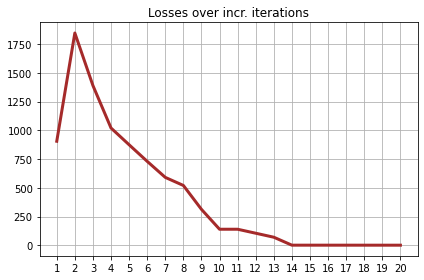

In [91]:
plt.title('Losses over incr. iterations')
plt.plot(np.arange(1,21), gbc.losses, lw=3, c='brown')
plt.xticks(np.arange(1,21))
plt.grid()
plt.tight_layout()
plt.show()
# 14 trees is enough

In [66]:
lgbc = LGBMClassifier(boosting_type='gbdt', max_depth=3, n_estimators=17, learning_rate=0.03, 
                      min_samples_leaf=20, random_state=seed, subsample=0.6, colsample_bytree=0.3)

lgbc.fit(X_train, y_train)

train_pred = lgbc.predict(X_train)
test_pred = lgbc.predict(X_test)
print(f'Train: \n', classification_report(y_train, train_pred, digits=3))
print(f'Test: \n', classification_report(y_test, test_pred, digits=3))

Train: 
               precision    recall  f1-score   support

           0      0.993     0.874     0.930       159
           1      0.930     0.996     0.962       267

    accuracy                          0.951       426
   macro avg      0.961     0.935     0.946       426
weighted avg      0.954     0.951     0.950       426

Test: 
               precision    recall  f1-score   support

           0      1.000     0.868     0.929        53
           1      0.928     1.000     0.963        90

    accuracy                          0.951       143
   macro avg      0.964     0.934     0.946       143
weighted avg      0.955     0.951     0.950       143



In [67]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000, n_features=15, n_informative=11, n_redundant=1, n_classes=2,
                           n_clusters_per_class=2, random_state=seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=seed)

In [68]:
gbc = GBClassifier(learning_rate=0.01, min_samples_leaf=20, n_estimators=28, reg_alpha=1.5, reg_lambda=2.5,
                   colsample_bytree=0.6, subsample=0.35)
gbc.fit(X_train, y_train)

train_pred = gbc.predict(X_train)
test_pred = gbc.predict(X_test)
print(f'Train: \n', classification_report(y_train, train_pred, digits=3))
print(f'Test: \n', classification_report(y_test, test_pred, digits=3))

Train: 
               precision    recall  f1-score   support

           0      0.895     0.936     0.915      3496
           1      0.933     0.891     0.911      3504

    accuracy                          0.913      7000
   macro avg      0.914     0.913     0.913      7000
weighted avg      0.914     0.913     0.913      7000

Test: 
               precision    recall  f1-score   support

           0      0.890     0.927     0.908      1498
           1      0.924     0.886     0.905      1502

    accuracy                          0.906      3000
   macro avg      0.907     0.906     0.906      3000
weighted avg      0.907     0.906     0.906      3000



In [85]:
gbc = GBClassifier(learning_rate=0.01, min_samples_leaf=20, n_estimators=35, colsample_bytree=0.6, subsample=0.35)
gbc.fit(X_train, y_train)

train_pred = gbc.predict(X_train)
test_pred = gbc.predict(X_test)
print(f'Train: \n', classification_report(y_train, train_pred, digits=3))
print(f'Test: \n', classification_report(y_test, test_pred, digits=3))

Train: 
               precision    recall  f1-score   support

           0      0.903     0.934     0.918      3496
           1      0.932     0.900     0.916      3504

    accuracy                          0.917      7000
   macro avg      0.918     0.917     0.917      7000
weighted avg      0.918     0.917     0.917      7000

Test: 
               precision    recall  f1-score   support

           0      0.898     0.925     0.911      1498
           1      0.922     0.895     0.909      1502

    accuracy                          0.910      3000
   macro avg      0.910     0.910     0.910      3000
weighted avg      0.910     0.910     0.910      3000



In [69]:
lgbc = LGBMClassifier(boosting_type='goss', max_depth=3, n_estimators=28, learning_rate=0.1, 
                      min_samples_leaf=10, random_state=seed, reg_alpha=1.5, reg_lambda=1.5)

lgbc.fit(X_train, y_train)

train_pred = lgbc.predict(X_train)
test_pred = lgbc.predict(X_test)
print(f'Train: \n', classification_report(y_train, train_pred, digits=3))
print(f'Test: \n', classification_report(y_test, test_pred, digits=3))

Train: 
               precision    recall  f1-score   support

           0      0.908     0.905     0.907      3496
           1      0.905     0.909     0.907      3504

    accuracy                          0.907      7000
   macro avg      0.907     0.907     0.907      7000
weighted avg      0.907     0.907     0.907      7000

Test: 
               precision    recall  f1-score   support

           0      0.908     0.891     0.900      1498
           1      0.893     0.910     0.902      1502

    accuracy                          0.901      3000
   macro avg      0.901     0.901     0.901      3000
weighted avg      0.901     0.901     0.901      3000

